In [1]:
import gymnasium           as gym 
import torch 
import torch.nn            as nn 
import torch.optim         as optim 
import torch.nn.functional as F
import random 
import math
import numpy               as np 
from collections import namedtuple, deque
# Visualization
import matplotlib.pyplot as plt 
from IPython import display



In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device 

'cuda'

In [3]:
env = gym.make('CartPole-v1', render_mode = 'human').env

In [4]:
plt.ion()

## Define Memory element

In [5]:
experience = namedtuple('experience',('state', 'action', 'next_state', 'reward'))

## Hyperparameters

In [6]:
# Maximmum memory size
MAX_MEMORY_SIZE = int(1e6) 

# Agent related parameters
LEARNING_RATE = 0.0001
BATCH_SIZE    = 128 
DISCOUNT_FACT = 0.99
TAU           = 0.005 

EPS_DECAY_RATE= 1e3 
EPS_INITIAL   = 1.00
EPS_FINAL     = 0.05

# Training epoches
TRAINING_EPOCHES = 1000

## Implementing DQN

### Implementing Replay Memory element

In [7]:
class ReplayMemory(object):
    def __init__(self):
        self.memory = deque(maxlen = MAX_MEMORY_SIZE)
    
    def push(self, state, action, next_state, reward):
        self.memory.append(experience(state, action, next_state, reward)) 
    
    def __len__(self):
        return len(self.memory)
    
    def select(self, batch_size):
        return random.sample(self.memory, batch_size)
        

### Neural Network Implementation

In [8]:
class QNN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(QNN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

### Agent Implementation

In [9]:
class Agent: 
    def __init__(self, env, input_params, actions):
        
        # Set up the values
        self.env       = env  
        self.inputs    = input_params 
        self.outputs   = actions 
        
        # Initialize identical target and policy networks 
        self.policy    = QNN(n_observations = input_params, n_actions = actions).to(device)
        self.target    = QNN(n_observations = input_params, n_actions = actions).to(device)
        self.target.load_state_dict(self.policy.state_dict()) 
        
        # Set up an optimizer and a memory element 
        self.memory    = ReplayMemory() 
        self.optimizer = optim.AdamW(self.policy.parameters(), lr = LEARNING_RATE)
        self.epsilon   = 1 
        
        # Count steps done 
        self.steps     = 0
        # Training visualizer 
        self.durations = []
    
    
    
    def act(self, state, select_random = False):
        
        # Choose an action 
        if select_random == False: 
            with torch.no_grad():
                return self.policy(state).max(1).indices.view(1,1) 
        else: 
            decide    = random.random()
            self.update_epsilon() 
            self.update_steps()
            if decide <= self.epsilon: 
                return torch.tensor([[self.env.action_space.sample()]], dtype = torch.long, device = device) 
            else: 
                with torch.no_grad():
                    return self.policy(state).max(1).indices.view(1,1) 
    
    def learn(self):
        # Learns ignorance!
        if len(self.memory) < BATCH_SIZE:
            return 
        
        samples = self.memory.select(BATCH_SIZE) 
        # Convert to batches 
        batches = experience(*zip(*samples)) 
        state_batch  = torch.cat(batches.state)
        action_batch = torch.cat(batches.action)
        reward_batch = torch.cat(batches.reward)
        # Identify the final states 
        masks  = torch.tensor(tuple(map(lambda x : x is not None, batches.next_state)), device = device, dtype = torch.bool)
        states = torch.cat([s for s in batches.next_state if s is not None])
        
        # Now calculate the values of the expectation of states
        Q_expected = self.policy(state_batch).gather(1, action_batch)
        
        # Now calculate the actual one from the next states
        Q_actual   = torch.zeros(BATCH_SIZE, device = device)
        with torch.no_grad():
            Q_actual[masks] = self.target(states).max(1).values 
        
        # Calculate the expectation
        Q_actual   = reward_batch + DISCOUNT_FACT * (Q_actual) 
        
        # Use Huber's loss 
        criterion  = nn.SmoothL1Loss()
        loss       = criterion(Q_actual.unsqueeze(1), Q_expected)
        
        # Training step of all the NNs
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(self.policy.parameters(),100) 
        self.optimizer.step() 
        
        # Update the target 
        self.soft_update()
    
    def train(self):
        # Training stuff
        for episode in range(1, TRAINING_EPOCHES + 1):
            # Reset environment
            state, _ = env.reset()
            state    = torch.tensor(state, dtype = torch.float32, device = device).unsqueeze(0)
            
            steps = 0
            while True:
                # Select an action 
                action = self.act(state, select_random = True)
                
                # Step
                next_state, reward, terminated, truncated, _ = env.step(action = action.item())
                
                # Adding all the experience to the memory 
                next_state = None if terminated else torch.tensor(next_state, dtype = torch.float32, device = device).unsqueeze(0)
                reward     = torch.tensor([reward], device = device)
                
                self.addtoexperience(state, action, next_state, reward)
                
                # Using this memory to learn
                self.learn() 
                
                # Update 
                state = next_state 
                done  = terminated or truncated 
                
            
                if done == True: 
                    self.durations.append(steps + 1) 
                    self.plot()
                    break 
                else: 
                    steps += 1 
            
            if np.mean(self.durations[-100:]) >= 1000:
                break 
            
        
            
        print("Completed Training")
        self.plot(show_result = True)
        plt.ioff()
        plt.show() 
                    
    def plot(self, show_result = False):
        plt.figure(1)
        durations = torch.tensor(self.durations, dtype = torch.float)

        if show_result:
            plt.title('Result')
        else: 
            plt.clf()
            plt.title('Training... Running average = ' + str(round(np.mean(self.durations[-100:]),2)))
        
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.plot(durations.numpy())
        
        if len(durations) >= 100:
            means = durations.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            
            plt.plot(means.numpy())
        plt.pause(0.001)
        
        
        
        if show_result: 
            display.display(plt.gcf())
        else: 
            display.display(plt.gcf())
            display.clear_output(wait = True) 
            
    def addtoexperience(self, state, action, next_state, reward):
        self.memory.push(state, action, next_state, reward)
        return 
    def update_epsilon(self):
        self.epsilon = EPS_FINAL + (EPS_INITIAL - EPS_FINAL) * math.exp((- self.steps)/EPS_DECAY_RATE)
        return 
    def update_steps(self):
        self.steps += 1
        return 
    def soft_update(self):
        target_net_state_dict = self.target.state_dict()
        policy_net_state_dict = self.policy.state_dict()
        
        for key in policy_net_state_dict:
            target_net_state_dict[key] = target_net_state_dict[key] + \
                                        TAU * (policy_net_state_dict[key] - target_net_state_dict[key])
        
        self.target.load_state_dict(target_net_state_dict) 
        return 
        
        

In [10]:
agent = Agent(env = env, input_params = 4, actions = 2)

Completed Training


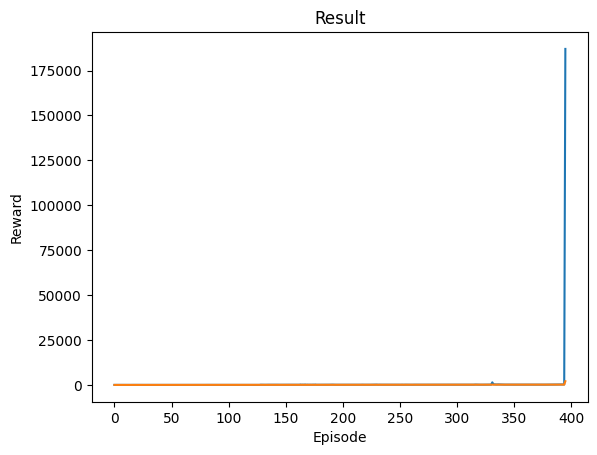

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [11]:
agent.train()

In [31]:
def test(agent, env, runs_num = 100):
    runs = []
    for _ in range(1, runs_num + 1):
        print("RUN #" + str(_)) 
        state, _ = env.reset()
        state    = torch.tensor(state, dtype = torch.float32, device = device).unsqueeze(0)
            
        total_reward = 0
        done  = False 
        while not done and total_reward < 500: 
            # Select an action 
            action = agent.act(state, select_random = False)
                
            # Step
            next_state, reward, terminated, truncated, _ = env.step(action = action.item())
            next_state = None if terminated else torch.tensor(next_state, dtype = torch.float32, device = device).unsqueeze(0)
            
            # Update 
            state = next_state 
            done  = terminated or truncated 
            
            total_reward += reward 
            
            print("Total reward:\t" + str(total_reward), end = '\r')
        
        runs.append(total_reward) 
        print()
    
    print("Mean of 100 trials\t", np.mean(runs))
    print("Standard deviation of 100 trials\t",np.std(runs)) 
         
            

In [32]:
test(agent, env)

RUN #1
Total reward:	500.0
RUN #2
Total reward:	500.0
RUN #3
Total reward:	500.0
RUN #4
Total reward:	500.0
RUN #5
Total reward:	500.0
RUN #6
Total reward:	500.0
RUN #7
Total reward:	500.0
RUN #8
Total reward:	500.0
RUN #9
Total reward:	500.0
RUN #10
Total reward:	500.0
RUN #11
Total reward:	500.0
RUN #12
Total reward:	500.0
RUN #13
Total reward:	500.0
RUN #14
Total reward:	500.0
RUN #15
Total reward:	500.0
RUN #16
Total reward:	500.0
RUN #17
Total reward:	500.0
RUN #18
Total reward:	500.0
RUN #19
Total reward:	500.0
RUN #20
Total reward:	500.0
RUN #21
Total reward:	500.0
RUN #22
Total reward:	500.0
RUN #23
Total reward:	500.0
RUN #24
Total reward:	500.0
RUN #25
Total reward:	500.0
RUN #26
Total reward:	500.0
RUN #27
Total reward:	500.0
RUN #28
Total reward:	500.0
RUN #29
Total reward:	500.0
RUN #30
Total reward:	500.0
RUN #31
Total reward:	500.0
RUN #32
Total reward:	500.0
RUN #33
Total reward:	500.0
RUN #34
Total reward:	500.0
RUN #35
Total reward:	500.0
RUN #36
Total reward:	500.0
R